In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from scipy.stats import linregress
import numpy as np

In [3]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list


# 使用示例（假设raw_df为原始数据）：
# '2019-12-01'
date_list = generate_date_range('2025-01-01', '2025-01-02')
# print(date_list)
raw_df = []
for date in date_list:
    raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
    # raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/tardis/orderbook/ETHUSDT/binance_book_snapshot_5_{date}_ETHUSDT.csv.gz'))

raw_df = pd.concat(raw_df)
print(raw_df.head())
# print(raw_df.tail())

           id    price    qty    quote_qty           time  is_buyer_maker
0  4936628773  3336.58  6.583  21964.70614  1735689605058           False
1  4936628774  3336.57  0.033    110.10681  1735689605064            True
2  4936628775  3336.58  1.135   3787.01830  1735689605072           False
3  4936628776  3336.57  0.460   1534.82220  1735689605079            True
4  4936628777  3336.57  0.231    770.74767  1735689605079            True


In [ ]:
series = raw_df['time']
print(series.astype(np.int64))

# print(series[0] > 1e11)

0          1735689605058
1          1735689605064
2          1735689605072
3          1735689605079
4          1735689605079
               ...      
4191869    1735862399845
4191870    1735862399942
4191871    1735862399942
4191872    1735862399942
4191873    1735862399982
Name: time, Length: 6687732, dtype: int64
0    True
0    True
Name: time, dtype: bool


In [24]:
def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')


In [30]:
def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    df = trades.copy()
    # 处理时间列和排序
    df['time'] = _ensure_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 核心改进：逐笔计算bar_id，确保连续递增
    cumulative = 0.0  # 累积成交额
    bar_id = 0        # 当前bar_id
    bar_ids = []      # 存储每个交易的bar_id
    
    for qty in df['quote_qty']:
        cumulative += qty
        # 当累积成交额达到阈值时，当前交易仍属于当前bar_id，随后bar_id递增并重置累积
        if cumulative >= dollar_threshold:
            bar_ids.append(bar_id)
            # 重置累积（保留超额部分，用于下一个bar的计算）
            cumulative -= dollar_threshold
            bar_id += 1
        else:
            bar_ids.append(bar_id)
    
    df['bar_id'] = bar_ids
    
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
    }
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume'
    ]
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g

In [46]:
dollar_bar = build_dollar_bars(raw_df, 10000 * 2000)

In [ ]:
# hour_counts = dollar_bar.end_time.dt.floor('H').value_counts().sort_index()
# hour_counts

end_time
2025-01-01 00:00:00    11
2025-01-01 01:00:00     7
2025-01-01 02:00:00     7
2025-01-01 03:00:00     4
2025-01-01 04:00:00     9
2025-01-01 05:00:00     6
2025-01-01 06:00:00     5
2025-01-01 07:00:00     4
2025-01-01 08:00:00     7
2025-01-01 09:00:00    24
2025-01-01 10:00:00     6
2025-01-01 11:00:00     9
2025-01-01 12:00:00     8
2025-01-01 13:00:00    10
2025-01-01 14:00:00    16
2025-01-01 15:00:00     9
2025-01-01 16:00:00    10
2025-01-01 17:00:00    10
2025-01-01 18:00:00     7
2025-01-01 19:00:00    10
2025-01-01 20:00:00     8
2025-01-01 21:00:00    10
2025-01-01 22:00:00     8
2025-01-01 23:00:00     6
2025-01-02 00:00:00    25
2025-01-02 01:00:00    14
2025-01-02 02:00:00     6
2025-01-02 03:00:00     6
2025-01-02 04:00:00    23
2025-01-02 05:00:00    13
2025-01-02 06:00:00     7
2025-01-02 07:00:00     8
2025-01-02 08:00:00    16
2025-01-02 09:00:00    23
2025-01-02 10:00:00    19
2025-01-02 11:00:00    12
2025-01-02 12:00:00    14
2025-01-02 13:00:00    25
202

In [48]:
dollar_bar

,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume,bar_id
0,2025-01-01 00:00:05.058,2025-01-01 00:06:43.904,3336.58,3342.30,3334.76,3339.85,6000.916,2.003799e+07,3697.788,2303.128,0
1,2025-01-01 00:06:43.904,2025-01-01 00:15:08.662,3339.90,3348.47,3339.86,3347.32,5970.300,1.996288e+07,3872.347,2097.953,1
2,2025-01-01 00:15:08.736,2025-01-01 00:18:20.098,3347.33,3352.53,3346.79,3350.13,5972.021,2.000784e+07,3756.689,2215.332,2
3,2025-01-01 00:18:20.098,2025-01-01 00:26:56.601,3350.12,3353.00,3346.43,3348.29,5969.329,1.999544e+07,2972.577,2996.752,3
4,2025-01-01 00:26:56.601,2025-01-01 00:31:29.708,3348.29,3354.04,3345.99,3353.63,5969.160,1.999805e+07,4845.069,1124.091,4
...,...,...,...,...,...,...,...,...,...,...,...
620,2025-01-02 23:09:09.162,2025-01-02 23:18:49.666,3441.05,3448.30,3437.00,3447.72,5809.949,1.999449e+07,2603.192,3206.757,620
621,2025-01-02 23:18:49.704,2025-01-02 23:27:57.063,3447.72,3450.81,3446.03,3450.80,5798.838,1.999614e+07,3566.480,2232.358,621
622,2025-01-02 23:27:57.063,2025-01-02 23:31:38.790,3450.80,3456.41,3449.85,3455.77,5792.800,2.000262e+07,4311.526,1481.274,622
623,2025-01-02 23:31:38.790,2025-01-02 23:43:30.969,3455.76,3456.01,3450.53,3452.43,5791.500,1.999696e+07,2181.236,3610.264,623


<Axes: >

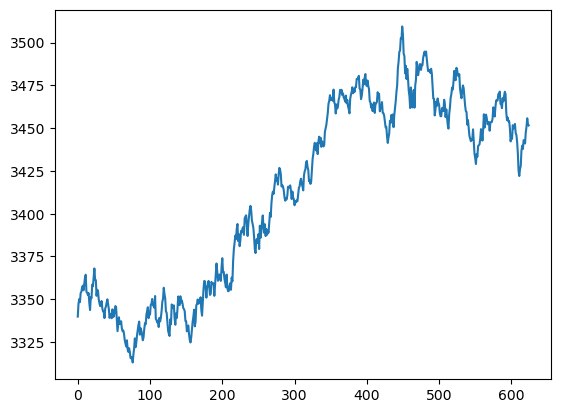

In [49]:
dollar_bar.close.plot()

In [56]:
def aggregate_trade_features_on_bars(
    trades: pd.DataFrame,
    bars: pd.DataFrame,
) -> pd.DataFrame:
    """
    将逐笔交易因子聚合到 dollar bar 轴上。
    输入 trades 列：['time','id','price','qty','quote_qty','is_buyer_maker']
    输出以 bar_id 为索引的交易侧特征。
    """
    df = trades.copy()
    df['time'] = _ensure_datetime(df['time'])
    df = df.sort_values('time')
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)

    # 基于 bars 的时间边界做区间切分（左闭右开）
    features = []
    for _, b in bars.iterrows():
        mask = (df['time'] >= b['start_time']) & (df['time'] < b['end_time'])
        seg = df.loc[mask]
        if seg.empty:
            features.append({
                'bar_id': int(b['bar_id']),
                'trade_vwap': np.nan,
                'trade_volume_sum': 0.0,
                'trade_dollar_sum': 0.0,
                'trade_signed_volume': 0.0,
                'trade_buy_ratio': np.nan,
                'trade_intensity': 0.0,
                'trade_rv': np.nan,
            })
            continue

        # VWAP
        dollar = seg['quote_qty'].sum()
        vwap = (seg['price'] * seg['qty']).sum() / seg['qty'].sum() if seg['qty'].sum() > 0 else np.nan

        # 强度与方向
        signed_volume = (seg['qty'] * seg['trade_sign']).sum()
        buy_ratio = (seg.loc[seg['trade_sign']>0,'qty'].sum()) / seg['qty'].sum() if seg['qty'].sum() > 0 else np.nan

        # 实现波动率（对价格取对数差）
        seg = seg.copy()
        seg['logp'] = np.log(seg['price'])
        rv = (seg['logp'].diff().dropna() ** 2).sum()

        duration_seconds = max(1.0, (b['end_time'] - b['start_time']).total_seconds())
        intensity = len(seg) / duration_seconds

        features.append({
            'bar_id': int(b['bar_id']),
            'trade_vwap': vwap,
            'trade_volume_sum': seg['qty'].sum(),
            'trade_dollar_sum': dollar,
            'trade_signed_volume': signed_volume,
            'trade_buy_ratio': buy_ratio,
            'trade_intensity': intensity,
            'trade_rv': rv,
            'start_time': b['start_time'],
            'end_time': b['end_time'],
            'close': b['close']
        })

    feat_df = pd.DataFrame(features).set_index('bar_id')
    return feat_df


In [57]:
trade_feat = aggregate_trade_features_on_bars(raw_df, dollar_bar)


In [58]:
trade_feat

,trade_vwap,trade_volume_sum,trade_dollar_sum,trade_signed_volume,trade_buy_ratio,trade_intensity,trade_rv,start_time,end_time,close
bar_id,,,,,,,,,,
0,3339.136899,5858.392,1.956197e+07,1252.136,0.606867,35.590178,0.000002,2025-01-01 00:00:05.058,2025-01-01 00:06:43.904,3339.85
1,3343.608078,6108.804,2.042545e+07,1920.938,0.657227,31.987606,0.000002,2025-01-01 00:06:43.904,2025-01-01 00:15:08.662,3347.32
2,3350.263977,5929.641,1.986586e+07,1583.737,0.633544,56.515923,0.000002,2025-01-01 00:15:08.736,2025-01-01 00:18:20.098,3350.13
3,3349.703333,5990.595,2.006672e+07,-87.669,0.492683,29.546779,0.000002,2025-01-01 00:18:20.098,2025-01-01 00:26:56.601,3348.29
4,3349.942003,5568.947,1.865565e+07,3320.765,0.798150,29.157070,0.000002,2025-01-01 00:26:56.601,2025-01-01 00:31:29.708,3353.63
...,...,...,...,...,...,...,...,...,...,...
620,3441.417758,5809.166,1.999177e+07,-602.782,0.448118,29.694886,0.000001,2025-01-02 23:09:09.162,2025-01-02 23:18:49.666,3447.72
621,3448.300294,5798.621,1.999539e+07,1334.339,0.615057,22.005667,0.000001,2025-01-02 23:18:49.704,2025-01-02 23:27:57.063,3450.80
622,3453.006651,5778.705,1.995391e+07,2844.347,0.746106,37.446951,0.000001,2025-01-02 23:27:57.063,2025-01-02 23:31:38.790,3455.77


In [59]:
trade_feat.trade_buy_ratio

bar_id
0      0.606867
1      0.657227
2      0.633544
3      0.492683
4      0.798150
         ...   
620    0.448118
621    0.615057
622    0.746106
623    0.375700
624    0.315360
Name: trade_buy_ratio, Length: 625, dtype: float64

<Axes: >

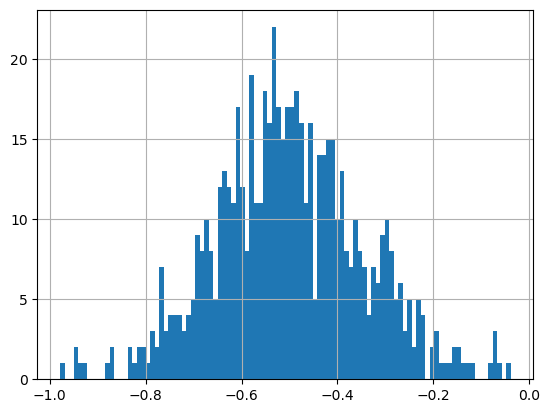

In [70]:
trade_buy_ratio = trade_feat.trade_buy_ratio - 0.5
(trade_buy_ratio).hist(bins = 100)

In [ ]:
# 在降频后的订单薄数据上加上一列————未来一个周期的收益率
resampled_z['ret_1'] = midprice.shift(-1)/midprice - 1
resampled_z['ret_3'] = midprice.shift(-3)/midprice - 1
resampled_z['ret_5'] = midprice.shift(-5)/midprice - 1

In [ ]:
# max_value=trade_buy_ratio.quantile(0.95)
# min_value=trade_buy_ratio.quantile(0.05)
# trade_buy_ratio_clipped_ = odb_imb.clip(min_value,max_value)

<Axes: >

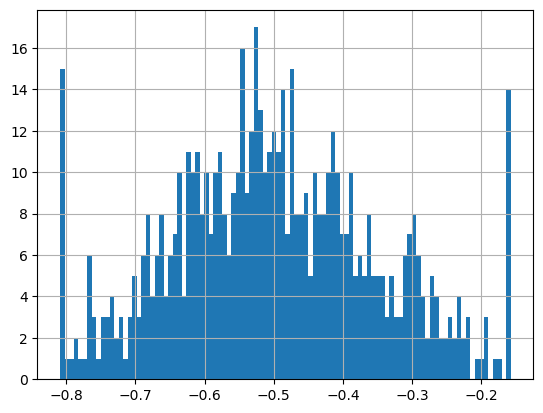

In [ ]:
# trade_buy_ratio_clipped_.hist(bins=100)

In [ ]:
ic_decay_list = []
for i in resampled_z.columns[9:]:
    ic_decay_list.append(resampled_clipped.corr(resampled_z[i]))
print(ic_decay_list)

count    621.000000
mean      -0.002375
std        1.047942
min       -1.997961
25%       -0.921664
50%        0.024077
75%        0.892156
max        1.938669
dtype: float64


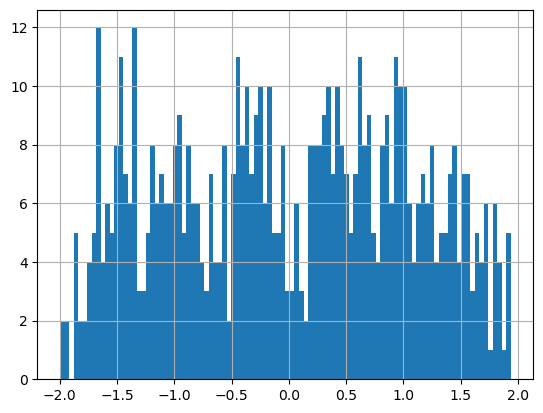

In [ ]:
# import talib as ta
# mean_ = ta.MA(trade_feat.trade_buy_ratio,5)
# std_ = ta.STDDEV(trade_feat.trade_buy_ratio,5)
# std_
# # 减去均值是做中心化处理，让因子值围绕均值分布。
# # 除以标准差是为了缩放
# trade_feat_norm = (trade_feat.trade_buy_ratio-mean_)/std_
# trade_feat_norm
# # # 因子要不要做處理？
# # # 觀察因子的分佈情況
# trade_feat_norm.hist(bins=100)
# print(trade_feat_norm.describe())
